# [ Main Quest 8. 주가 추세 판단 분류기 만들기 ]

#### (작업 순서)
- 데이터 업로드 및 시각화
- 데이터 라벨링: 과거 데이터에 대해 추세 레이블 부여
- 피처 엔지니어링: 예측에 유용한 다양한 특성 생성
- 모델 훈련 및 평가: 지도학습 알고리즘을 사용하여 모델을 훈련시키고 성능 평가

#### (결과)
- split 개수, 데이터 개수, 모델 추가, 파라미터 변경 등 다양한 시도를 하였으나,
- 연산 수행시간이 과도하게 소요되어 모델 성능 평가까지 마치지 못하고, 23번 셀(모델 훈련)에서 강제 종료 후 제출함
- 23번 셀 이후는 코드만 기록되어 있음

In [1]:
import datetime, sys, os, re, io, json, ta, shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sml

sys.path.append('/aiffel/aiffel/fnguide/data/')
from tqdm import tqdm
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from libs.mlutil.pkfold import PKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve


import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 업로드 및 시각화

<AxesSubplot:xlabel='time'>

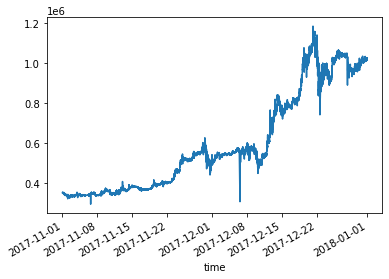

In [2]:
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

# 2. 데이터 라벨링

## 2-1. Price Change Direction

- 다음 코드는 주가 데이터에서 모멘텀 신호를 계산하고, 특정 날짜의 종가 데이터를 기반으로 색깔이 있는 산점도를 그리는 작업
- window를 기존 10에서 6으로 변경함으로써, 모멘텀 신호를 계산할 때 더 짧은 기간(6일)의 종가 데이터를 사용하게 되어 모멘텀 신호가 더 민감하고 빠르게 반응하지만, 그만큼 더 많은 노이즈가 포함될 가능성이 있음 

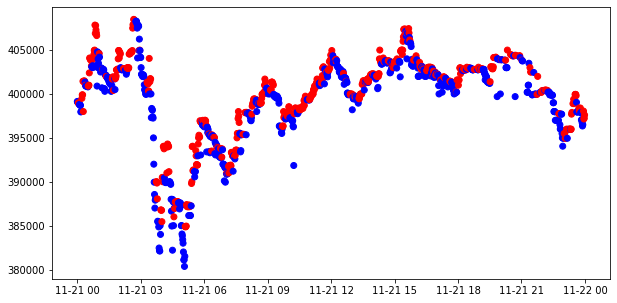

In [3]:
# 기존 분석은 10이었으나, 6으로 변경
window = 6
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

## 2-2. Using Moving Average

- 다음 코드는 주가 데이터에서 이동 평균을 기준으로 모멘텀 신호를 계산하고, 특정 날짜의 종가 데이터를 색깔이 있는 산점도로 시각화
- 이동 평균을 기준으로 주가가 상승하는지 하락하는지에 따라 모멘텀 신호를 생성하며, 이를 기반으로 주가 데이터 포인트를 빨간색(상승) 또는 파란색(하락)으로 표시

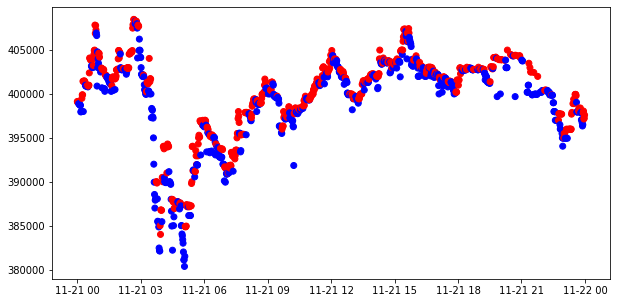

In [4]:
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

## 2-3. Loval Min-Max

- 다음 코드는 주가 데이터에서 지역적 최소값과 최대값을 찾아 이를 시각화하는 작업을 수행
- 이를 통해 주가 흐름에서 중요한 변곡점을 시각적으로 쉽게 확인 가능

In [5]:
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

               min_time  local_min
0   2017-11-21 00:01:00     399050
1   2017-11-21 00:03:00     399000
2   2017-11-21 00:04:00     398900
3   2017-11-21 00:05:00     398850
4   2017-11-21 00:06:00     398800
..                  ...        ...
472 2017-11-21 23:48:00     397850
473 2017-11-21 23:50:00     397050
474 2017-11-21 23:52:00     396750
475 2017-11-21 23:53:00     396350
476 2017-11-21 23:59:00     397600

[477 rows x 2 columns]
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3   2017-11-21 00:19:00     401350
4   2017-11-21 00:20:00     401500
..                  ...        ...
268 2017-11-21 23:41:00     398050
269 2017-11-21 23:43:00     398400
270 2017-11-21 23:46:00     398200
271 2017-11-21 23:47:00     398400
272 2017-11-21 23:56:00     398050

[273 rows x 2 columns]


(376546.5, 412585.0)

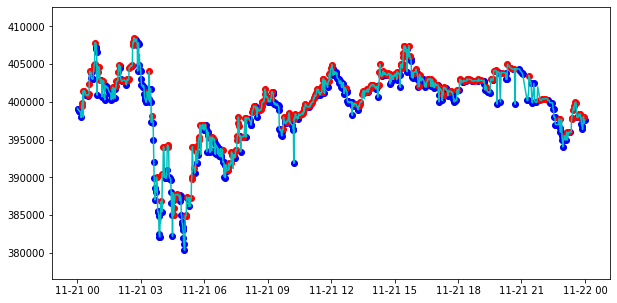

In [6]:
mins, maxes = get_local_min_max(sub_data, wait=3)

print(mins)
print('--'*20)
print(maxes)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')

ax.scatter(mins.min_time, mins.local_min, c='blue')
ax.scatter(maxes.max_time, maxes.local_max, c='red')

ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

## 2-4. Trend Scanning

- 다음 코드는 주가 데이터에서 일정 기간 동안의 선형 회귀를 통해 t-값을 계산하고, 이를 기반으로 주가의 상승 또는 하락 신호를 생성하여 시각화하는 작업을 수행
- 이를 통해 주가 데이터에서 통계적으로 유의한 변화를 시각적으로 확인

In [7]:
def t_val_lin_r(close):    
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit() 
    return ols.tvalues[1]

100%|██████████| 33384/33384 [13:49<00:00, 40.23it/s]


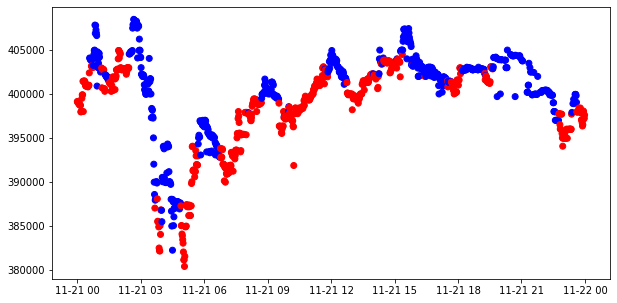

In [8]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

# 3. 피처 엔지니어링

## 3-1. 데이터 불러오기

- 기존 분석과 다르게 5,000개의 데이터 사용

In [9]:
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

df_sub_modify_data = df_sub_modify_data.iloc[:5000]

## 3-2. Technical Index 적용

- 다음 코드는 주가 데이터에서 다양한 기술적 지표를 계산한 후, 이를 사용하여 랜덤 포레스트 분류기 모델을 학습시킴
- 주가 데이터의 패턴을 학습하여 예측할 수 있는 모델을 생성
- mt 변수는 지표 계산에서 사용하는 윈도우 크기를 조정하는 데 사용되는 배율로 기술적 지표의 계산에서 사용되는 기간(window)을 조정하는 역할
- mt = 1로 설정은 윈도우 크기가 20

In [10]:
mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()

df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()

df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()

df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [11]:
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [12]:
df_tmp_data = df_.join(df_label_data).dropna()

X = df_tmp_data.iloc[:, 5:-1] 
y = df_tmp_data.iloc[:, -1]

sc = StandardScaler()

X_sc = sc.fit_transform(X)
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

rfc = RandomForestClassifier(class_weight='balanced')

rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

## 3-3. Feature Selection Methods 적용

### MDI

- 다음 코드는 학습된 랜덤 포레스트 분류기 모델(rfc)을 사용하여 각 특성(변수)의 중요도를 계산

In [13]:
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.043336,0.000742
volume_fi,0.051549,0.001378
volume_mfi,0.042065,0.000857
volume_sma_em,0.055710,0.001031
volume_vpt,0.029494,0.000676
volatility_atr,0.051001,0.000905
volatility_ui,0.044793,0.000882
trend_macd_diff,0.055421,0.001929
trend_adx,0.058508,0.000993
trend_trix,0.048006,0.000916


### MDA

- 다음 코드는 특성 중요도를 시각화하고, 이를 바탕으로 모델의 예측에 영향을 미치는 주요 특성을 식별하는 작업을 수행
- n_splites를 기존 5에서 4로 변경하여 훈련 데이터의 비율이 늘어나고, 평가의 변동성이 증가하며, 계산 시간이 줄어드는 효과
- Tree 및 Support Vector Machine 외에 Logistic Regression 적용

In [14]:
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path) 
    else:
        plt.show()

In [15]:
svc_rbf = SVC(kernel='rbf', probability=True) 
cv = KFold(n_splits=5) 
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

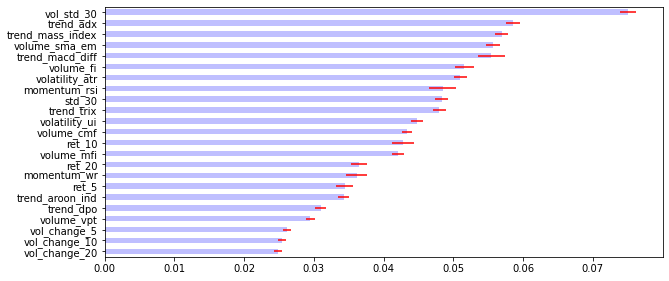

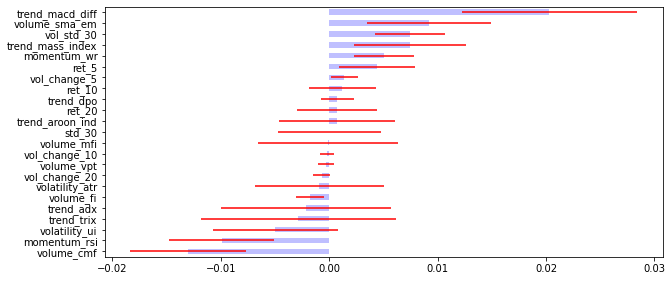

In [16]:
plot_feature_importance(feat_imp)
plot_feature_importance(feat_imp_mda)

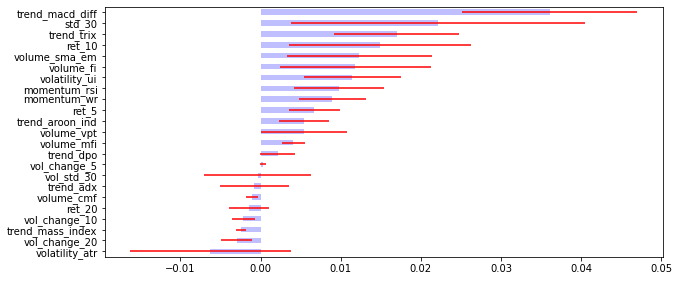

In [17]:
# Logistic Regression
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)
log_reg = LogisticRegression(max_iter=1000)
cv = KFold(n_splits=5)

feat_imp_mda_log_reg = imp.mean_decrease_accuracy(log_reg, X_sc, y, cv_gen=cv)
plot_feature_importance(feat_imp_mda_log_reg)

### RFE CV

- 다음 코드는 선형 커널을 사용하는 서포트 벡터 머신(SVM) 모델을 활용하여 재귀적 특성 제거(RFE) 방법을 통해 최적의 특성 집합을 선택하는 작업을 수행
- 중요한 특성을 선택하고, 그 결과를 데이터프레임으로 나타내는 작업을 수행

In [18]:
svc_rbf = SVC(kernel='linear', probability=True) 
rfe_cv = RFECV(svc_rbf, cv=cv)
rfe_fitted = rfe_cv.fit(X_sc, y)

rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})
rfe_df

,Optimal_Features,Ranking
volume_cmf,False,15
volume_fi,False,11
volume_mfi,False,9
volume_sma_em,True,1
volume_vpt,False,12
volatility_atr,False,10
volatility_ui,False,3
trend_macd_diff,True,1
trend_adx,False,14
trend_trix,False,2


### SFS

- 다음 코드는 SFS을 사용하여 주어진 데이터에서 최적의 두 개의 특성(n=2)을 선택하는 작업을 수행
- 데이터에서 가장 중요한 두 개의 특성을 선택하고, 그 특성의 이름을 반환

In [19]:
n = 2
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

sfs_rank = sfs_fitted.get_support()
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns={"Optimal_Features"})

sfs_df [sfs_df ["Optimal_Features"]==True].index

Index(['momentum_rsi', 'ret_10'], dtype='object')

### SHAP

- 다음 코드는 SHAP을 사용하여 랜덤 포레스트 모델의 예측 결과를 해석하고, 그 결과를 시각화하는 작업을 수행
- 랜덤 포레스트 모델의 예측을 해석하기 위해 SHAP 값을 계산하고 시각화하며, 최종 데이터를 파일로 저장

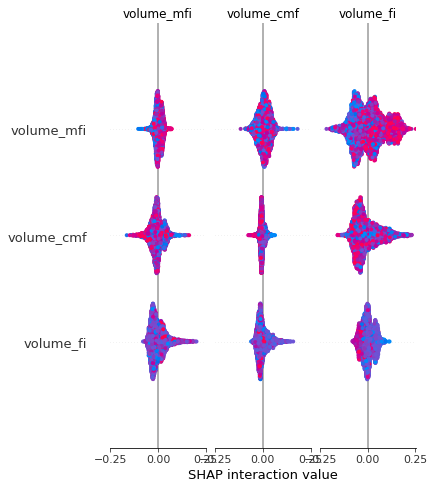

In [20]:
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

shap.summary_plot(shap_value, X_sc)
output_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
df_tmp_data.to_pickle(output_file_name)

# 4. 모델 훈련 및 평가

## 4-1. 학습, 테스트 데이터 셋 만들기

- 기본 분석과 다르게 10,000개의 데이터 사용

In [21]:
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)
df_data['t_value'].value_counts()

train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

sc = StandardScaler()
X_sc = sc.fit_transform(X)

train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

train_x = train_x[:10000] 
train_y = train_y[:10000]

## 4-2. Purged K-fold for Cross-Validation 적용

- 다음 코드는 교차 검증 설정을 구성하는 작업임
- n_cv = 4는 교차 검증을 수행할 때 데이터를 4개의 폴드로 나누겠다는 것을 의미
- 기존 분석은 n_cv = 4로 하였으나, 5로 변경하여 모델의 안정성과 평가의 변동성을 줄이고자 함

In [22]:
n_cv = 5
t1 = pd.Series(train_y.index.values, index=train_y.index)
cv = PKFold(n_cv, t1, 0)

## 4-3. Model 훈련

- 다음 코드는 BaggingClassifier를 사용하여 RandomForestClassifier의 성능을 개선하고, GridSearchCV를 통해 최적의 하이퍼파라미터를 찾는 작업을 수행
- GridsearchCV에서 사용할 파라미터 설정을 변경하고 이유를 첨부함

In [23]:
bc_params = {
    'n_estimators': [10, 50, 100],  # 더 많은 추정기를 사용하여 성능 향상을 기대할 수 있음
    'max_features': [0.5, 0.75, 1.0],  # 다양한 특성 비율을 시도하여 최적의 값을 찾음
    'base_estimator__max_depth': [3, 5, 10],  # 더 깊은 트리를 허용하여 모델의 복잡성을 조절함
    'base_estimator__max_features': [None, 'sqrt', 'log2'],  # 다양한 max_features 옵션을 시도하여 최적의 값을 찾음
    'base_estimator__min_samples_leaf': [1, 2, 4],  # 노드에 필요한 최소 샘플 수를 조정하여 과적합 방지
    'bootstrap_features': [False, True]  # 부트스트랩 샘플링을 사용할지 여부를 시도
}

rfc = RandomForestClassifier(class_weight='balanced')
bag_rfc = BaggingClassifier(rfc)
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)

gs_rfc.fit(train_x, train_y)

gs_rfc_best = gs_rfc.best_estimator_
gs_rfc_best.fit(train_x, train_y)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


KeyboardInterrupt: 

## 4-4. 모델 평가

- 다음 코드는 최적화된 랜덤 포레스트 모델을 사용하여 테스트 데이터를 예측하고, 그 예측 결과를 평가하는 작업임

In [ ]:
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y) 
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

- 다음 코드는 ROC 곡선을 생성하고 시각화하며, AUC값을 계산하여 모델의 분류 성능을 평가하는 작업임

In [ ]:
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')